### **Housing Prices Prediciton - Analysis Stage**

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

In [93]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import sqlite3
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error



In [94]:
#class for he db
database_name = 'house_prices.db'

# connect to the db
conn = sqlite3.connect(database_name)

train_df = pd.read_sql_query(
    "SELECT * FROM train", 
    conn)

test_df = pd.read_sql_query(
    "SELECT * FROM test", 
    conn)

# Close the connection
conn.close()

# view of data in the database
pd.set_option('display.max_columns', None)
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000


<Figure size 1400x800 with 0 Axes>

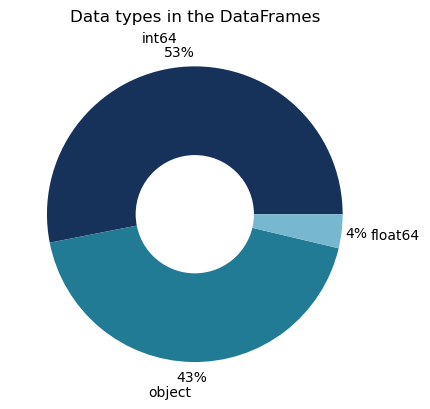

In [95]:
colors = ['#16325B', '#227B94', '#78B7D0' ,'#FFDC7F']
names = ['int64', 'object', 'float64']
datatype_chart = pd.DataFrame(train_df.dtypes.value_counts()).reset_index(names=['data_type', 'count']).sort_values(by='count', ascending=False)

plt.figure(figsize=(14,8))
datatype_chart.plot(kind='pie', y='count',autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2,
                                                  colors=colors,labels=names,legend=False
                                                  )
centre_circle = plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf() 
fig.gca().add_artist(centre_circle)
plt.title('Data types in the DataFrames', fontsize=12)
plt.ylabel('')
plt.show()

In [96]:
pd.set_option('display.max_rows', None)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [97]:
pd.set_option('display.max_columns', None)
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


#### **Sales Price Distribution**

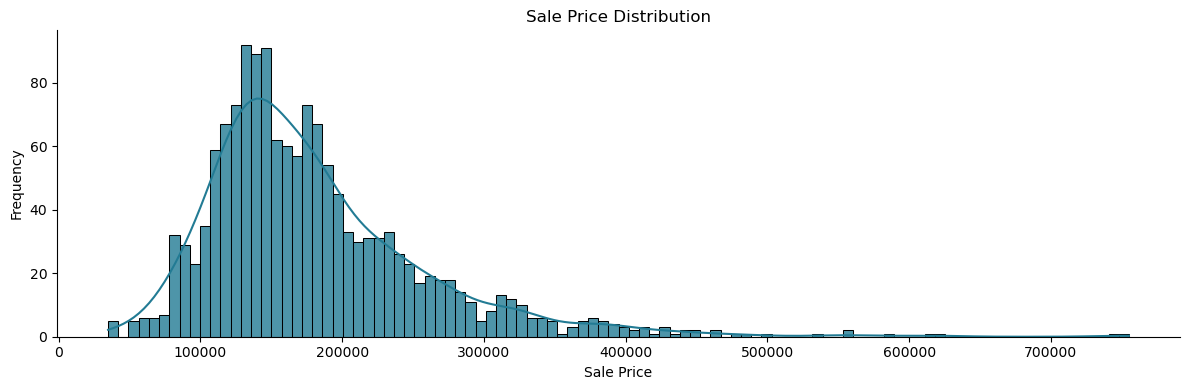

In [98]:
# distribution of the sale price with in the dataset 
sns.displot(train_df['SalePrice'],kde=True, color='#227B94', height=4, aspect=3, bins=100, alpha=0.8) 
plt.title('Sale Price Distribution', fontsize=12)
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.tight_layout()
sns.despine()
plt.show()

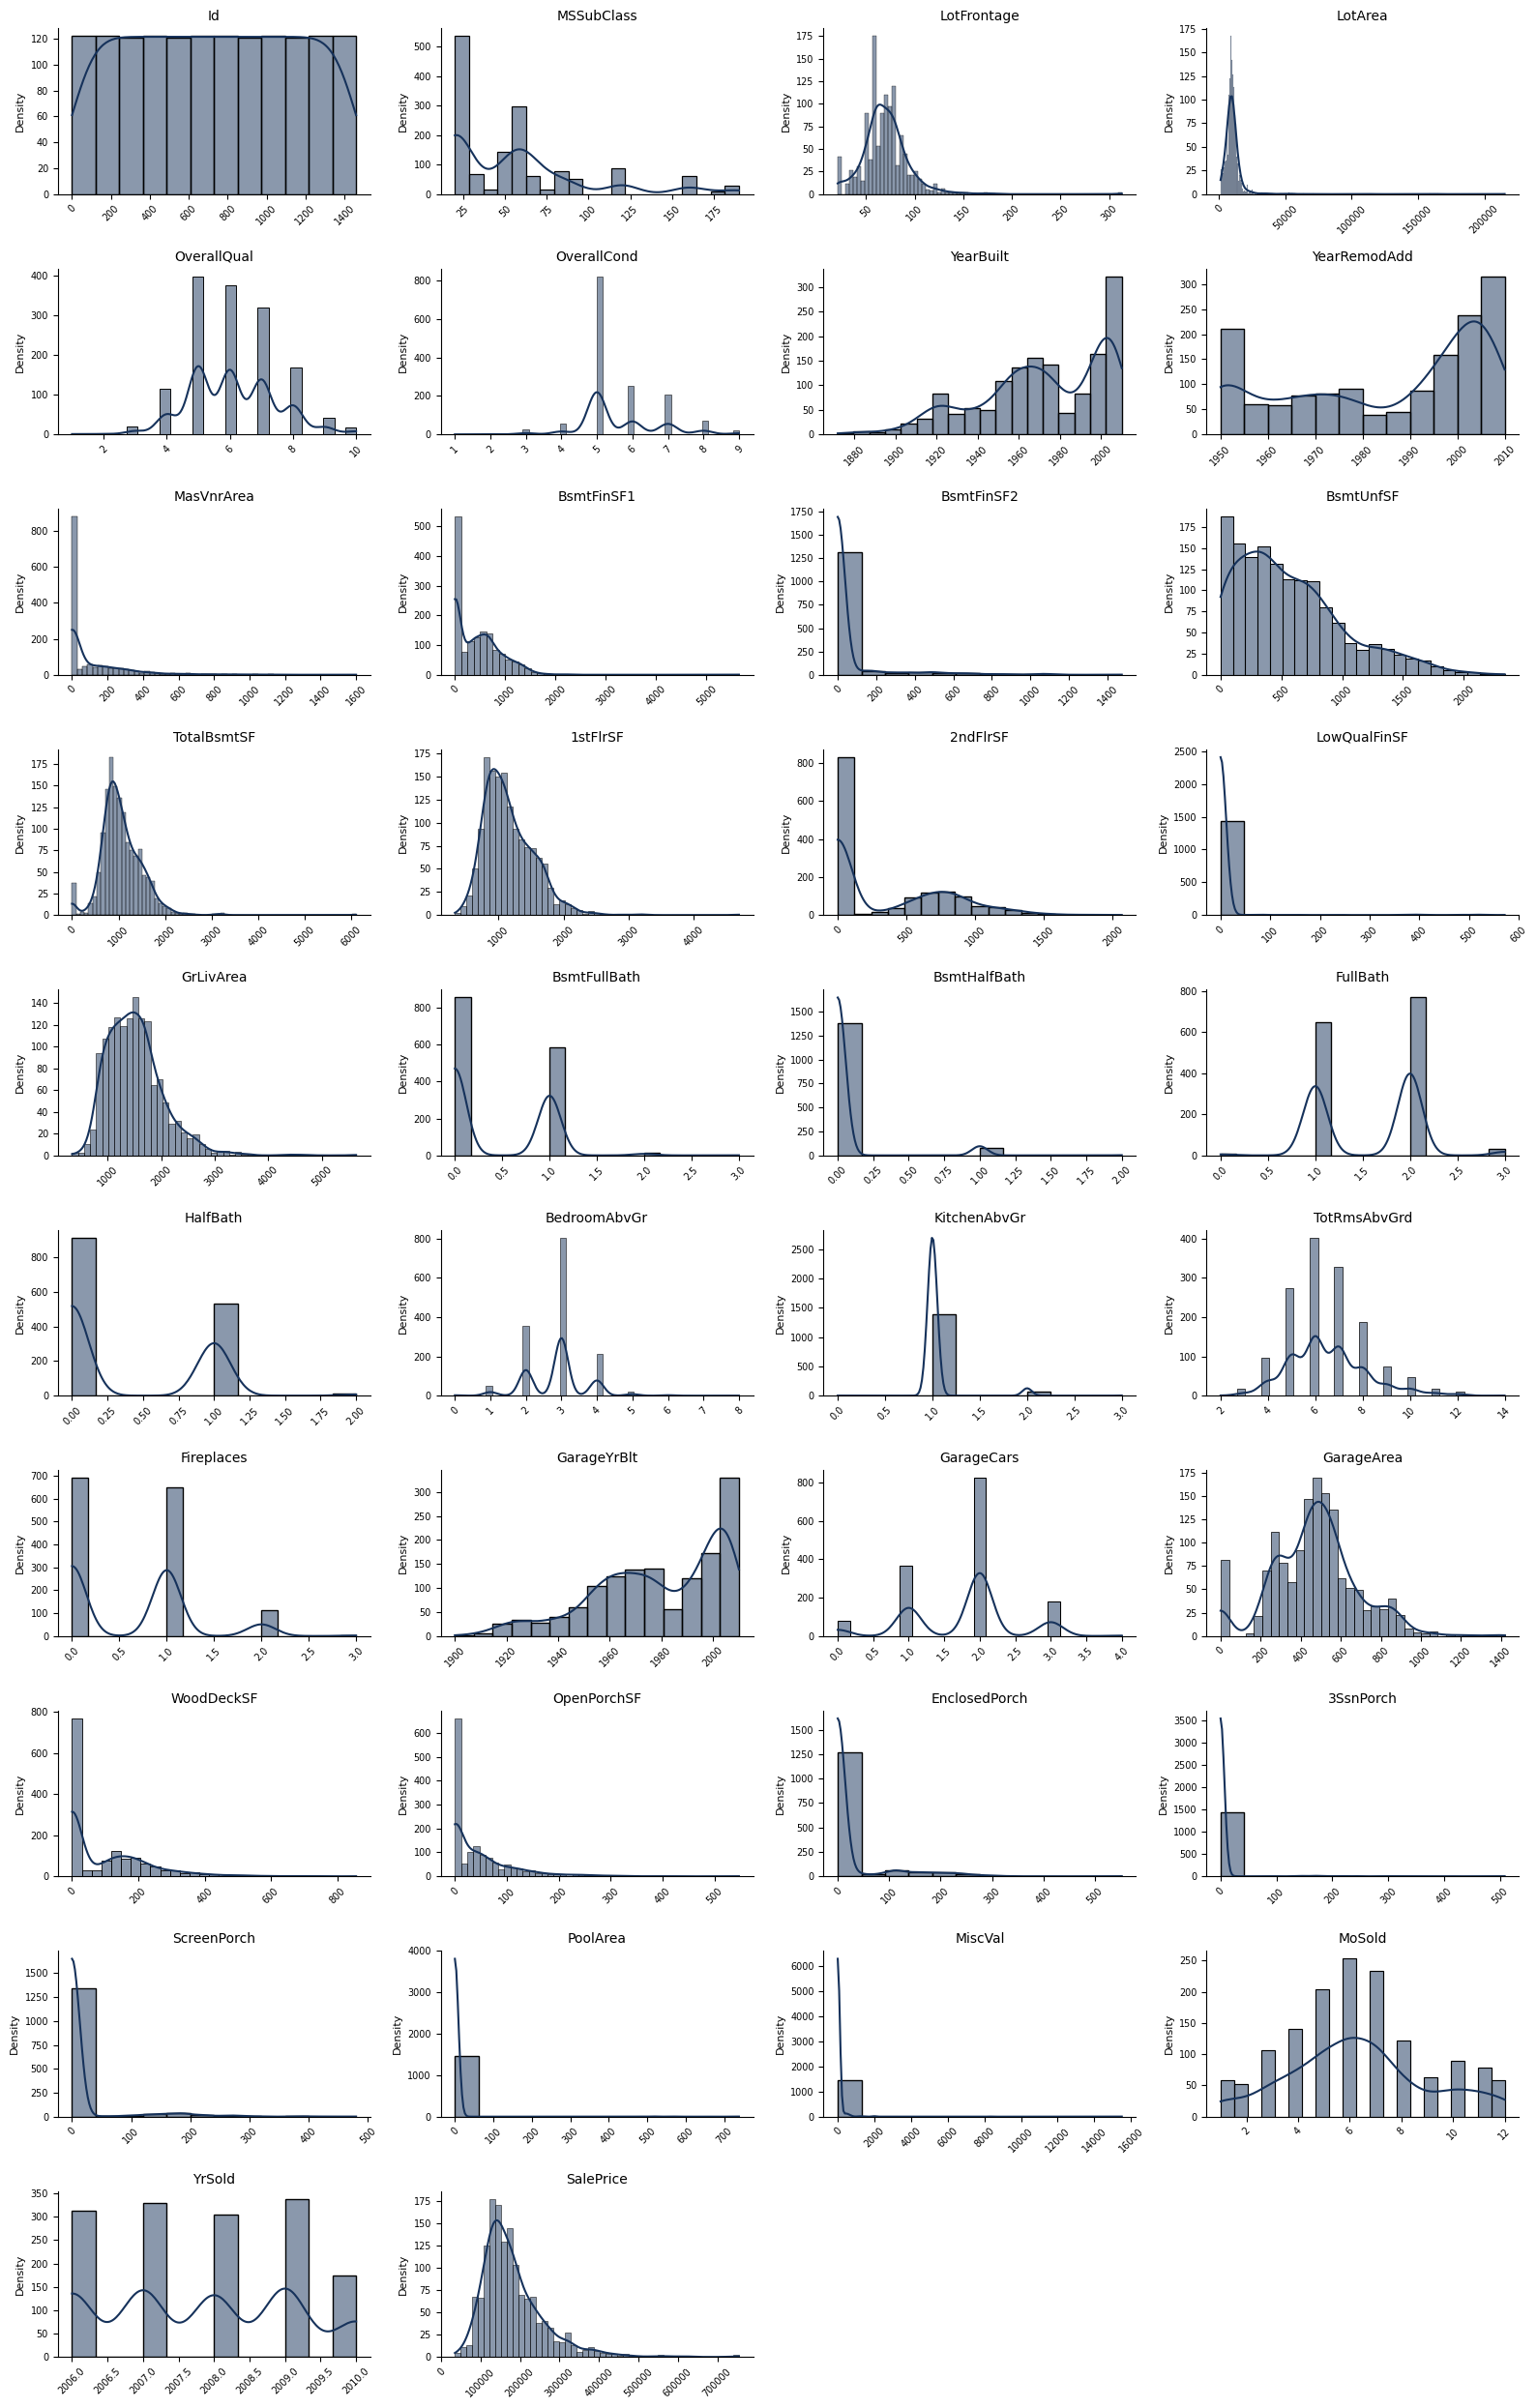

In [99]:
#select only numerical columns
numerical_cols = train_df.select_dtypes(include=['number']).columns
# Define number of columns and calculate rows
ncols = 4 
nrows = (len(numerical_cols) + ncols - 1) // ncols 
#figure size
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2.5 * nrows)) 
axes = axes.flatten() 

#plot for each col
for i, col in enumerate(numerical_cols):
    sns.histplot(train_df[col], kde=True, ax=axes[i], color='#16325B')
    axes[i].set_title(col, fontsize=10)  
    axes[i].tick_params(axis='x', rotation=45, labelsize=7)  
    axes[i].tick_params(axis='y', labelsize=7)
    axes[i].set_xlabel('') 
    axes[i].set_ylabel('Density', fontsize=8)
if len(numerical_cols) < len(axes):
    for j in range(len(numerical_cols), len(axes)):
        fig.delaxes(axes[j])
plt.tight_layout()
sns.despine()
plt.show()

In [100]:
numerical_cols = train_df.select_dtypes(include=['number']).columns
numerical_dataset = train_df[numerical_cols]
numerical_dataset['SalePrice'] = train_df['SalePrice']
numerical_dataset.head()

#melting the numerical dataset
numerical_dataset_melted = pd.melt(numerical_dataset, id_vars='SalePrice', var_name='numerical_Variable', value_name='Category')
numerical_dataset_melted[numerical_dataset_melted['numerical_Variable']  == 'Street'].head( )

grouped_stats_num = numerical_dataset_melted.groupby(['numerical_Variable', 'Category'])['SalePrice'].agg([
    'count',
    'mean',
    'sum',
    'std'
]).round(2).reset_index()

grouped_stats_num.head()

C:\Users\Dell\AppData\Local\Temp\ipykernel_12564\4031819983.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerical_dataset['SalePrice'] = train_df['SalePrice']


,numerical_Variable,Category,count,mean,sum,std
0,1stFlrSF,334.0,1,39300.00,39300,NaN
1,1stFlrSF,372.0,1,55000.00,55000,NaN
2,1stFlrSF,438.0,1,60000.00,60000,NaN
3,1stFlrSF,480.0,1,35311.00,35311,NaN
4,1stFlrSF,483.0,7,96628.57,676400,12403.59


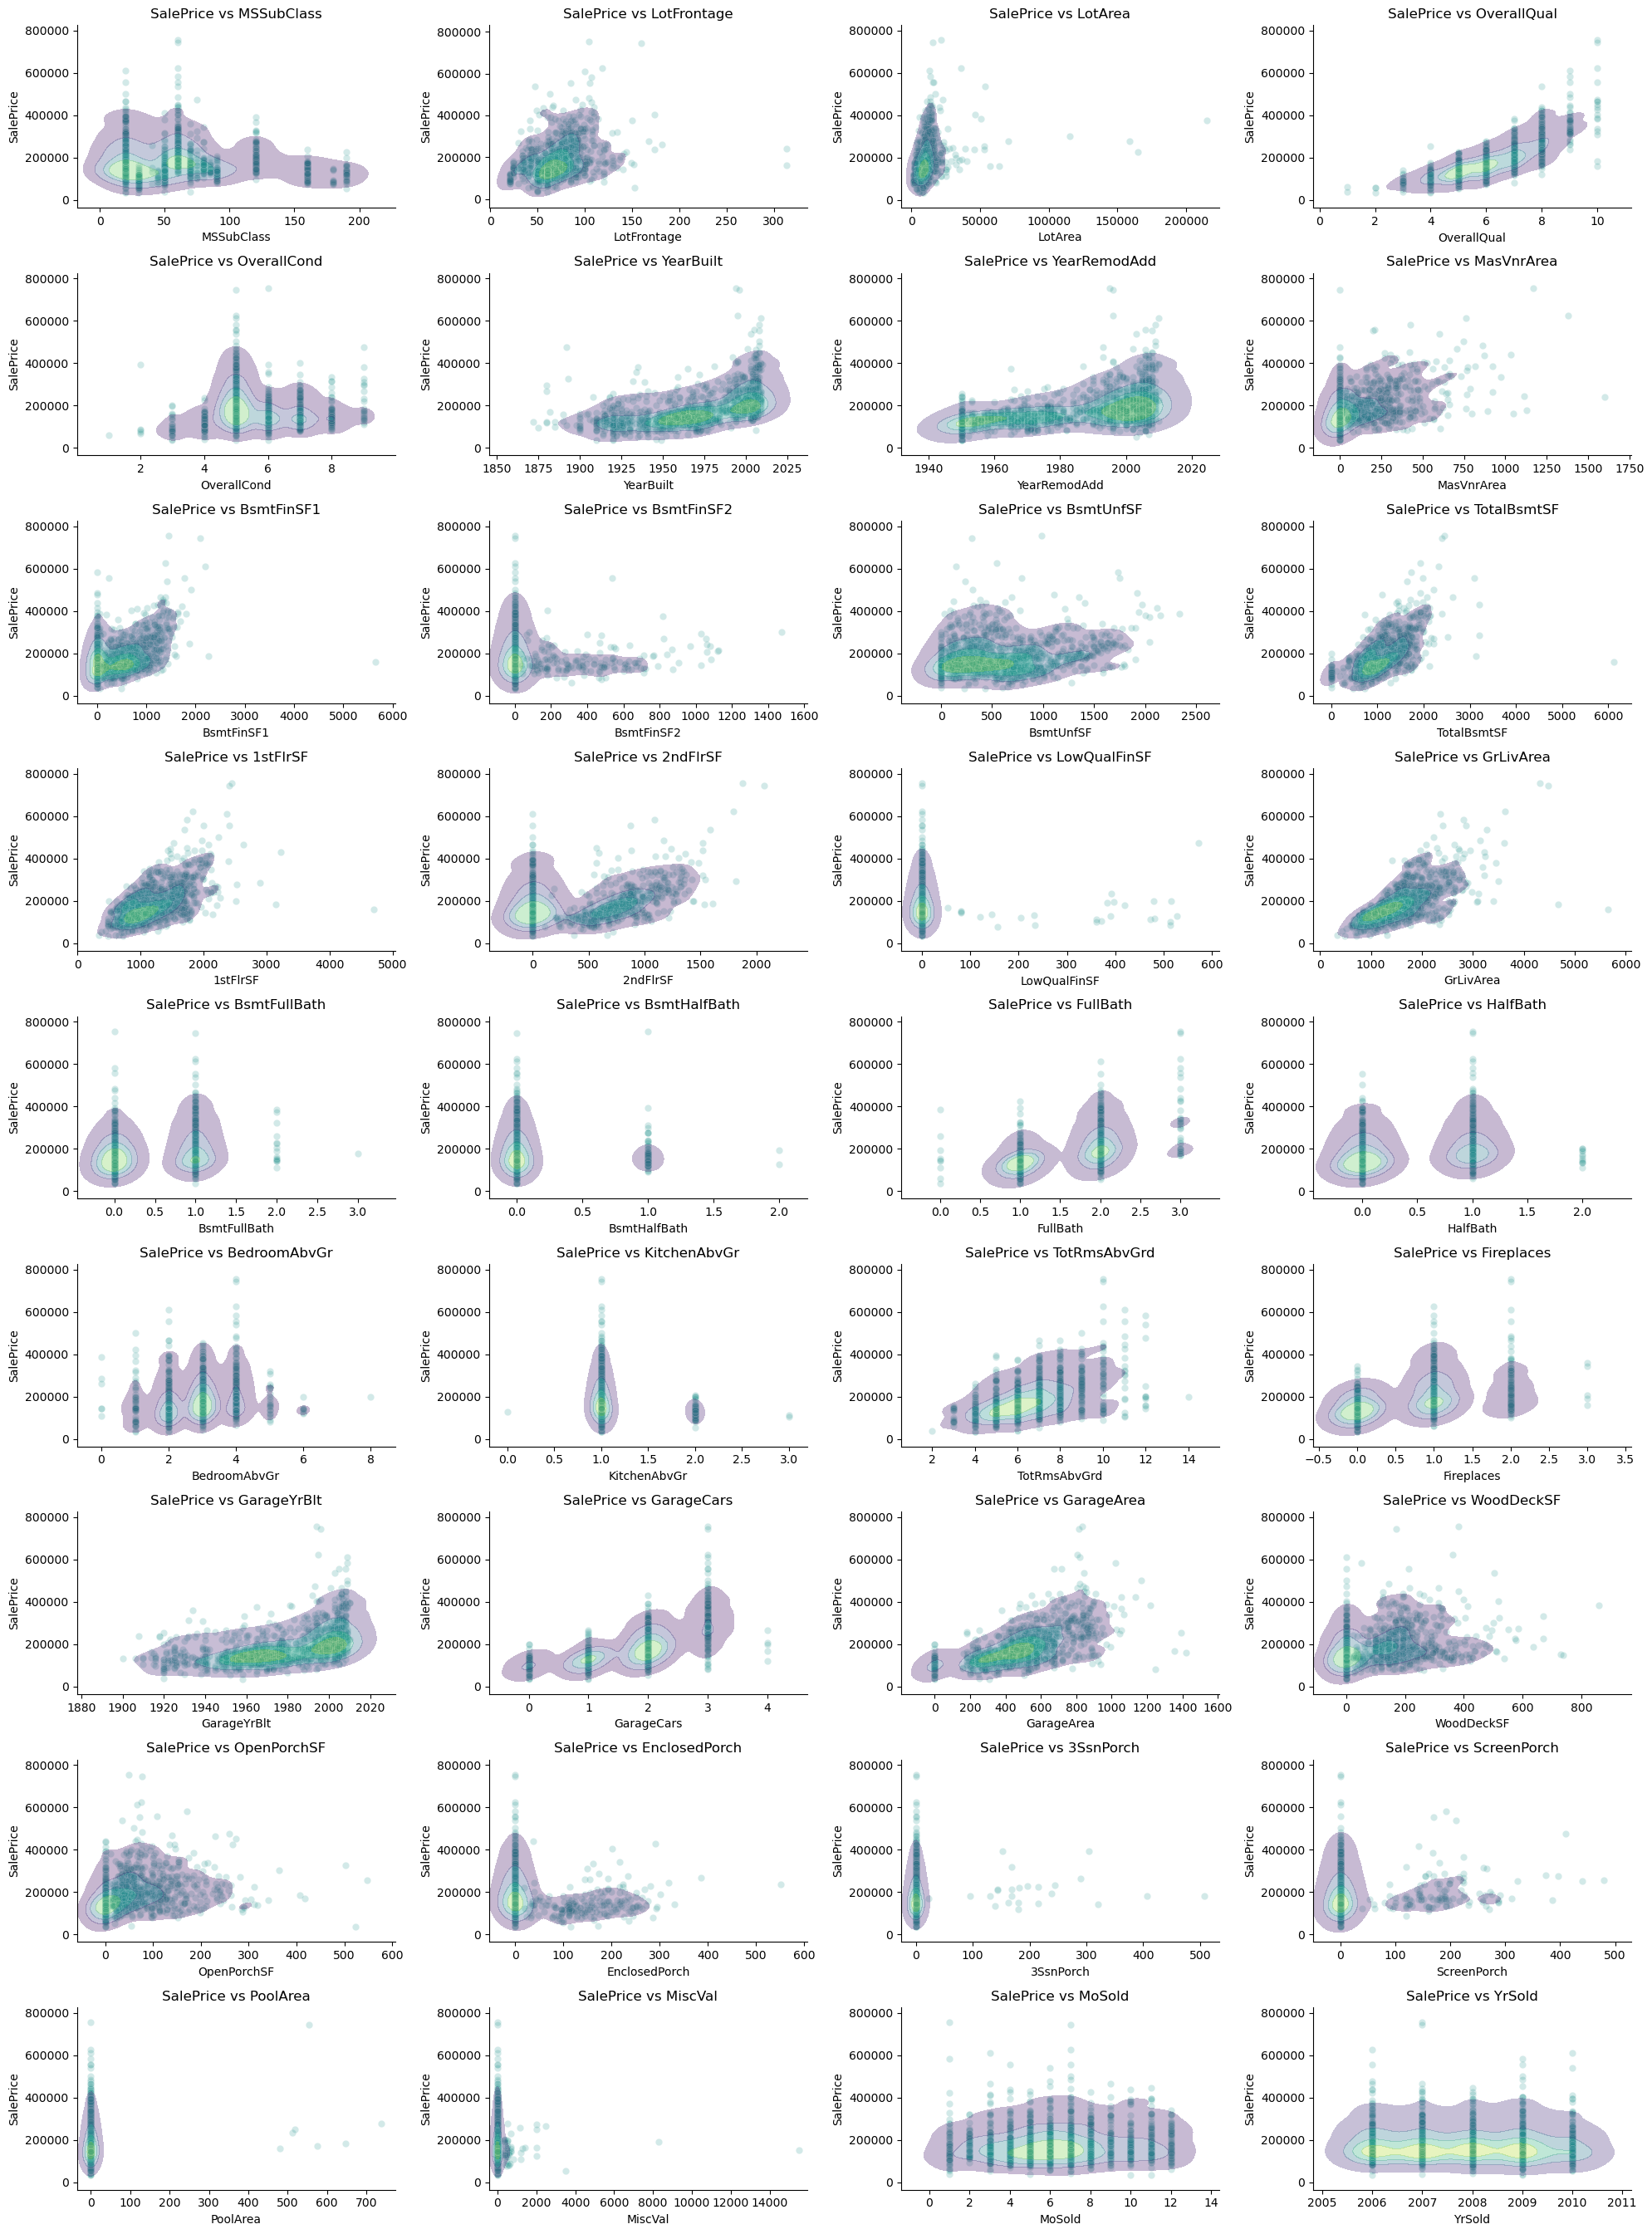

In [101]:
numerical_cols = numerical_dataset.select_dtypes(include=['int64', 'float64']).columns
plot_cols = [col for col in numerical_cols if col not in ['Id', 'SalePrice']]  
# Set up the subplot grid
n_plots = len(plot_cols)
n_cols = 4
n_rows = (n_plots + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3 * n_rows))
axes = axes.flatten()

#create plot with pallte and color
viridis_color = sns.color_palette('viridis', as_cmap=True)(0.5)
for i, col in enumerate(plot_cols):
    ax = axes[i]
    sns.scatterplot(data=numerical_dataset, x=col, y='SalePrice', ax=ax, color=viridis_color, alpha=0.2)
    sns.kdeplot(data=numerical_dataset, x=col, y='SalePrice', ax=ax, fill=True, alpha=0.3, cmap='viridis', levels=5)
    ax.set_title(f'SalePrice vs {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('SalePrice')

# Hide unused axes
for i in range(n_plots, n_rows * n_cols):
    axes[i].axis('off')

plt.tight_layout()
sns.despine()
plt.show()

### **Categorical Variables**

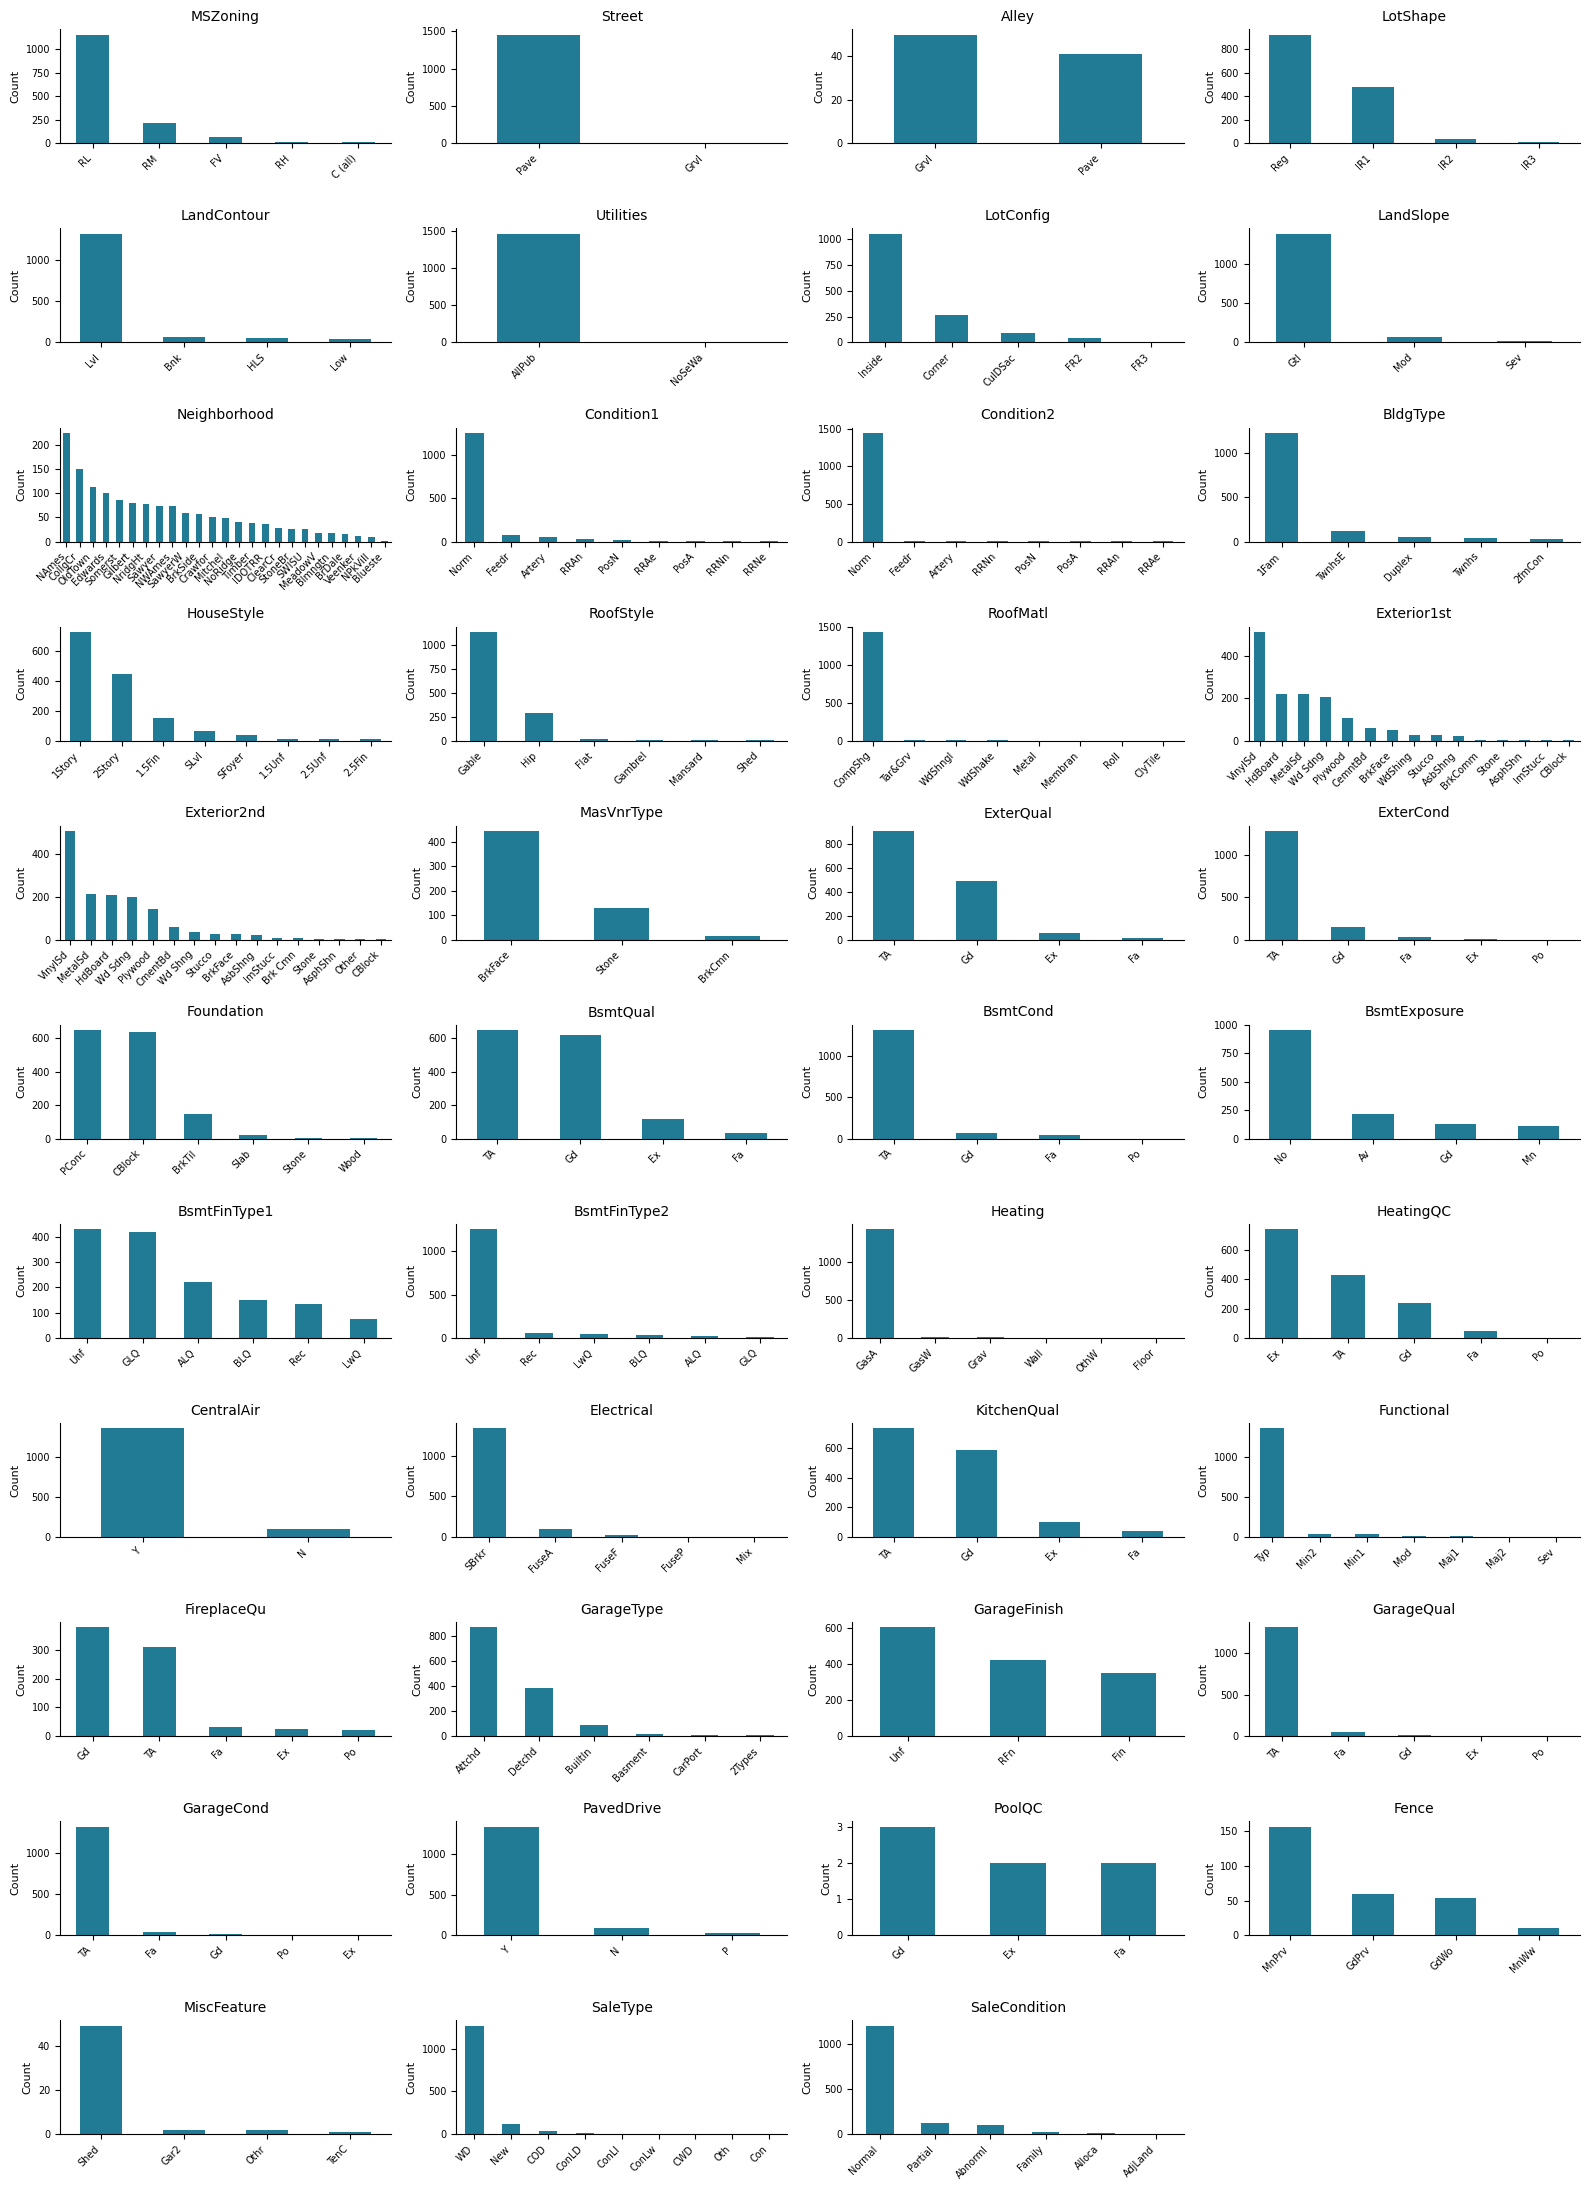

In [102]:
# Select categorical columns
categorical_cols = train_df.select_dtypes(include=['object']).columns
ncols = 4 
nrows = (len(categorical_cols) + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2 * nrows)) 
axes = axes.flatten() 
for i, col in enumerate(categorical_cols):
    train_df[col].value_counts().plot(kind='bar', ax=axes[i], color='#227B94')
    axes[i].set_title(col, fontsize=10) 
    axes[i].set_xlabel('')  
    axes[i].set_ylabel('Count', fontsize=8)  
    axes[i].tick_params(axis='x', rotation=45, labelsize=7)  
    axes[i].tick_params(axis='y', labelsize=7) 
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right') 

# Turn off any unused subplots
if len(categorical_cols) < len(axes):
    for j in range(len(categorical_cols), len(axes)):
        fig.delaxes(axes[j])
plt.tight_layout()
sns.despine()  
plt.show()

#### **Relationship between Categorical Variables and House Price**

In [103]:
categorical_cols = train_df.select_dtypes(include=['object']).columns
categorical_dataset = train_df[categorical_cols]
categorical_dataset['SalePrice'] = train_df['SalePrice']
categorical_dataset.head(2)

C:\Users\Dell\AppData\Local\Temp\ipykernel_12564\617430293.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_dataset['SalePrice'] = train_df['SalePrice']


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,SalePrice
0,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,None,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal,208500
1,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal,181500


In [104]:
#melting the categorical dataset
categorical_dataset_melted = pd.melt(categorical_dataset, id_vars='SalePrice', var_name='Categorical_Variable', value_name='Category')
categorical_dataset_melted[categorical_dataset_melted['Categorical_Variable']  == 'Street'].head( )

grouped_stats = categorical_dataset_melted.groupby(['Categorical_Variable', 'Category'])['SalePrice'].agg([
    'count',
    'mean',
    'sum',
    'std'
]).round(2).reset_index()

grouped_stats.head(2)

,Categorical_Variable,Category,count,mean,sum,std
0,Alley,Grvl,50,122219.08,6110954,34780.78
1,Alley,Pave,41,168000.59,6888024,38370.38


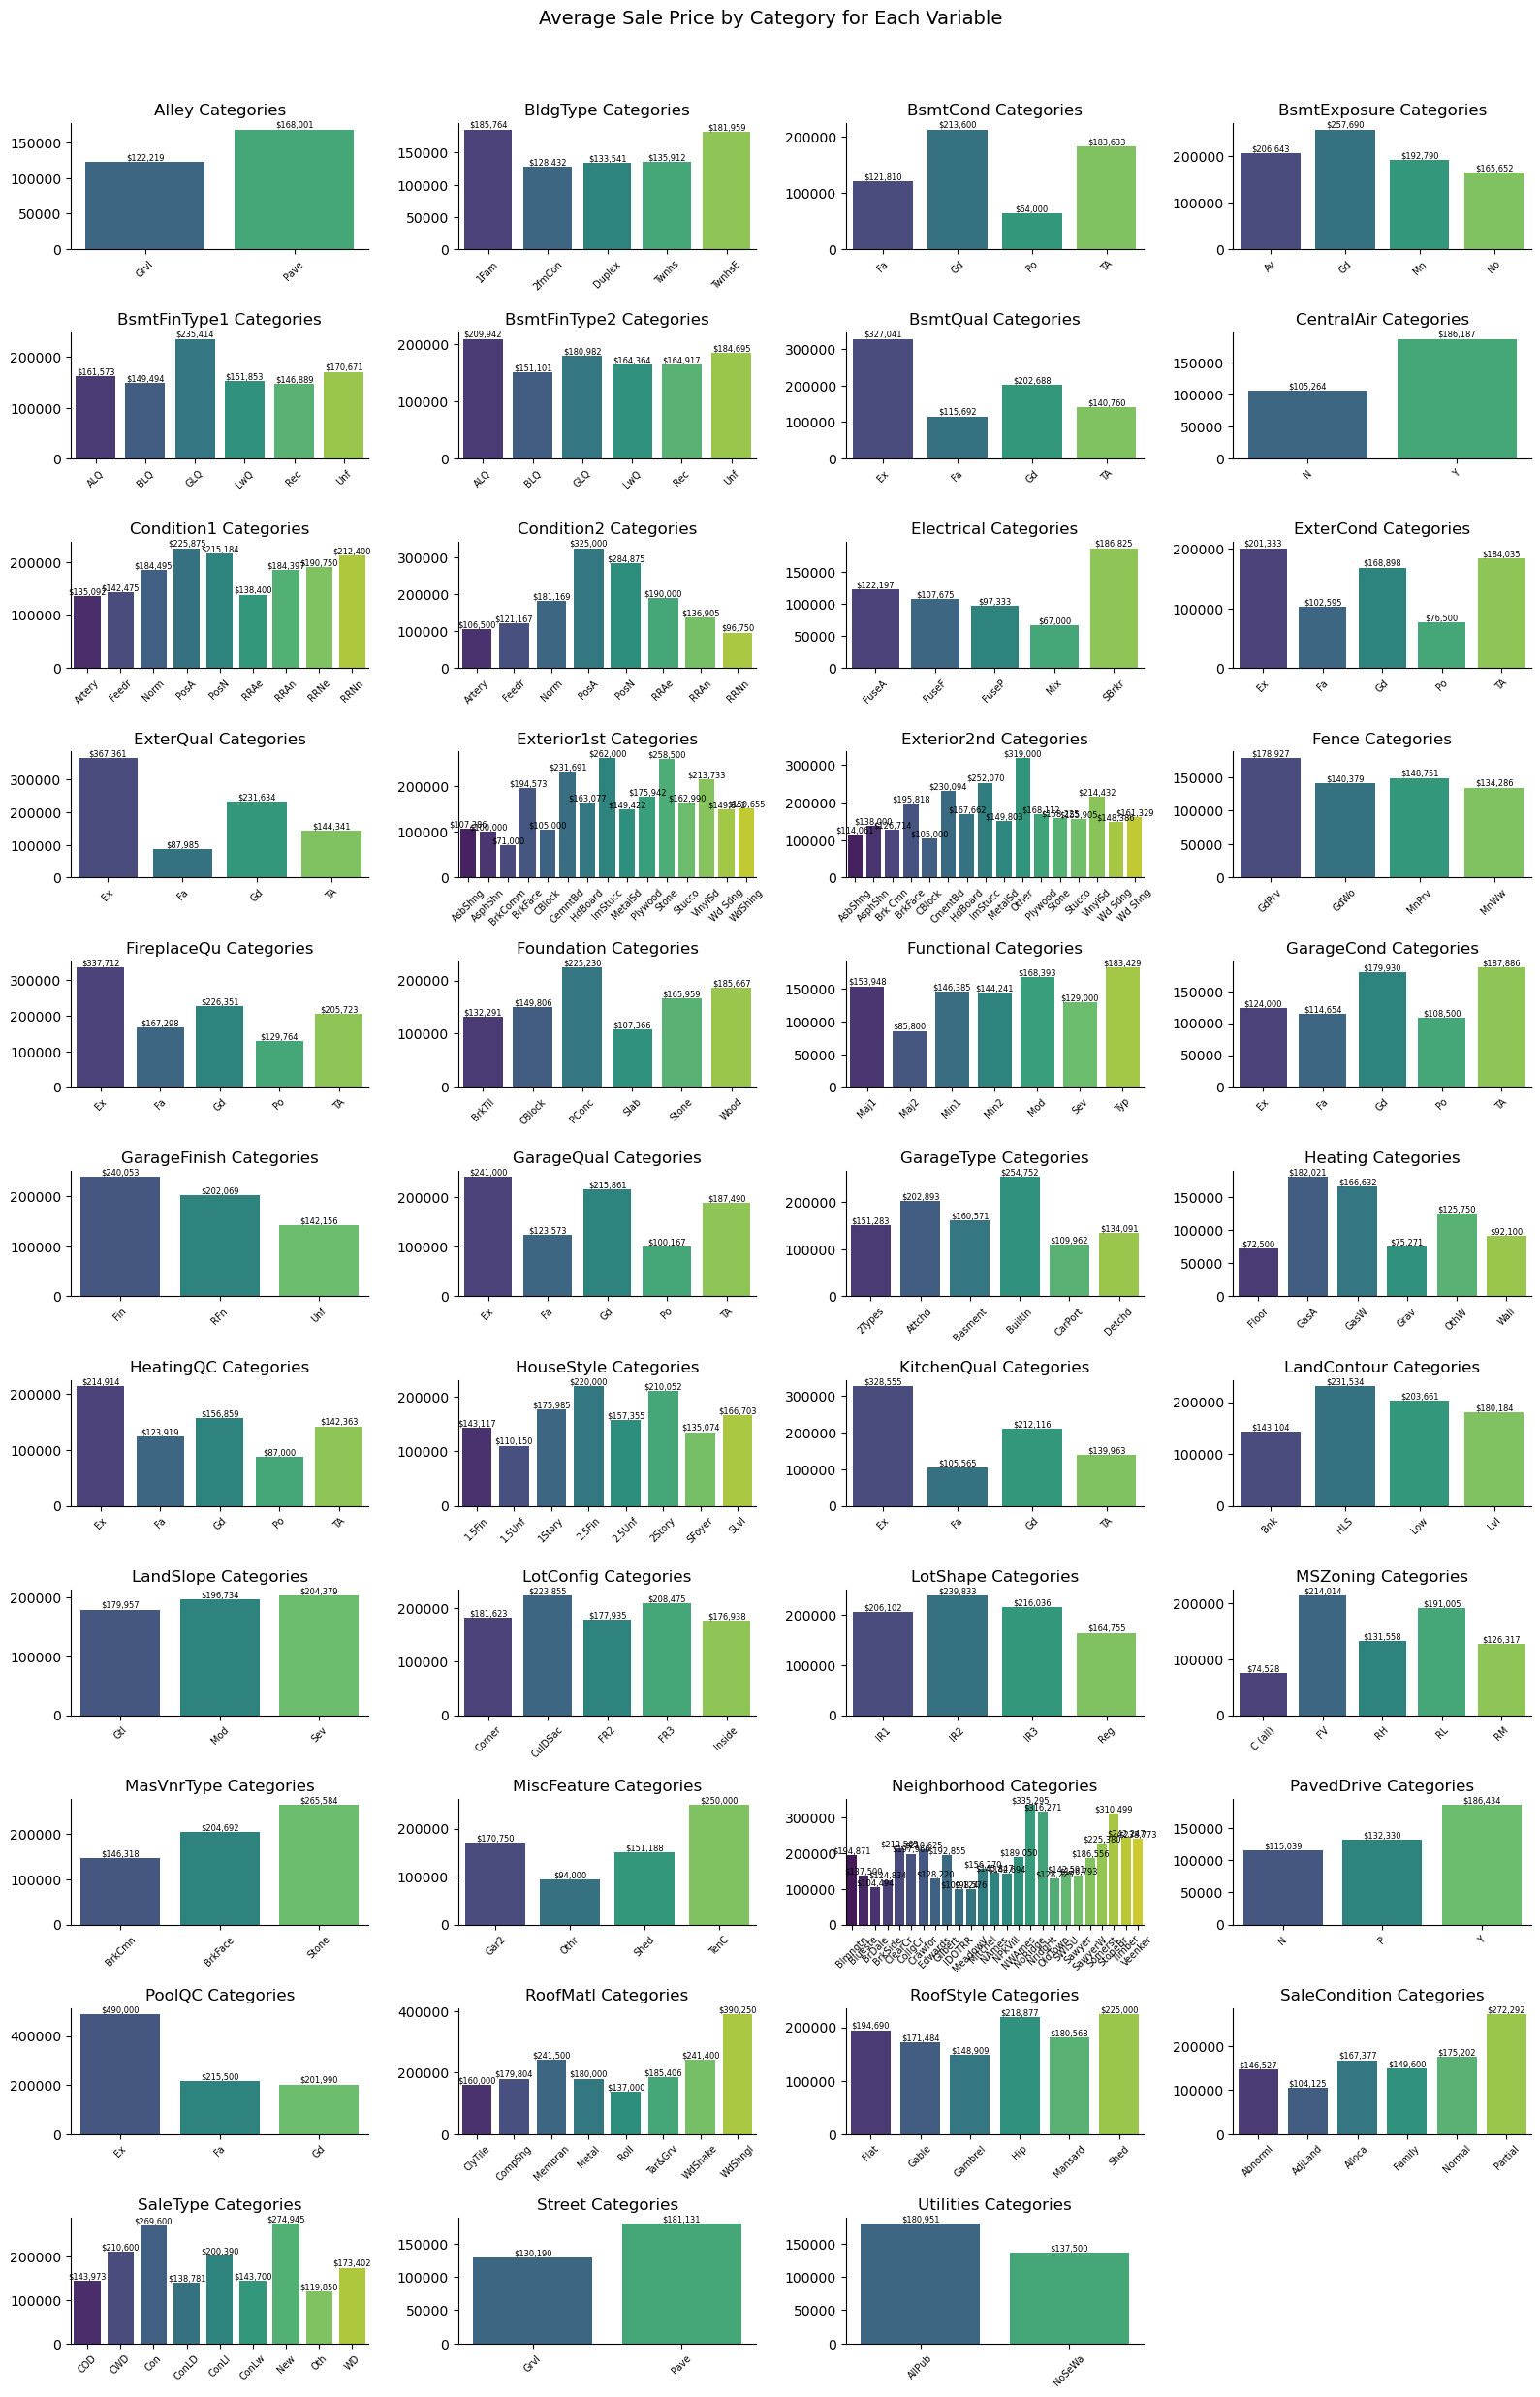

In [106]:
groups = grouped_stats.groupby('Categorical_Variable')
ncols, fig_w = 4, 16  # 4 columns and wider figure
nrows = (len(groups) + 3) // 4  # Calculate rows needed

fig, axes = plt.subplots(nrows, ncols, figsize=(fig_w, 2.2 * nrows))  # Wider and shorter
fig.suptitle('Average Sale Price by Category for Each Variable', fontsize=14, y=1.02)

for idx, (category, data) in enumerate(groups):
    ax = axes.flat[idx]
    sns.barplot(data=data, x='Category', y='mean', ax=ax, palette='viridis')
    ax.set(title=f'{category} Categories', xlabel='', ylabel='')
    ax.tick_params(axis='x', rotation=45, labelsize=7)
    for p in ax.patches:
        ax.annotate(f'${p.get_height():,.0f}', (p.get_x()+p.get_width()/2., p.get_height()),
                    ha='center', va='bottom', fontsize=6)

# Turn off empty subplots
[ax.axis('off') for ax in axes.flat[len(groups):]]
plt.tight_layout()
sns.despine()
plt.show()

In [26]:
# Print summary statistics
for category in unique_categories:
    print(f"\nSummary for {category}:")
    summary = categorical_dataset_melted[categorical_dataset_melted['Categorical_Variable'] == category].groupby('Category')['SalePrice'].agg([
        'count',
        'mean',
        'sum',
        'std'
    ]).round(2)
    print(summary)


Summary for Alley:
          count       mean      sum       std
Category                                     
Grvl         50  122219.08  6110954  34780.78
Pave         41  168000.59  6888024  38370.38

Summary for BldgType:
          count       mean        sum       std
Category                                       
1Fam       1220  185763.81  226631845  82648.50
2fmCon       31  128432.26    3981400  35458.55
Duplex       52  133541.08    6944136  27833.25
Twnhs        43  135911.63    5844200  41013.22
TwnhsE      114  181959.34   20743365  60626.11

Summary for BsmtCond:
          count       mean        sum       std
Category                                       
Fa           45  121809.53    5481429  43467.80
Gd           65  213599.91   13883994  72663.16
Po            2   64000.00     128000   4242.64
TA         1311  183632.62  240742366  79515.39

Summary for BsmtExposure:
          count       mean        sum        std
Category                                        
A

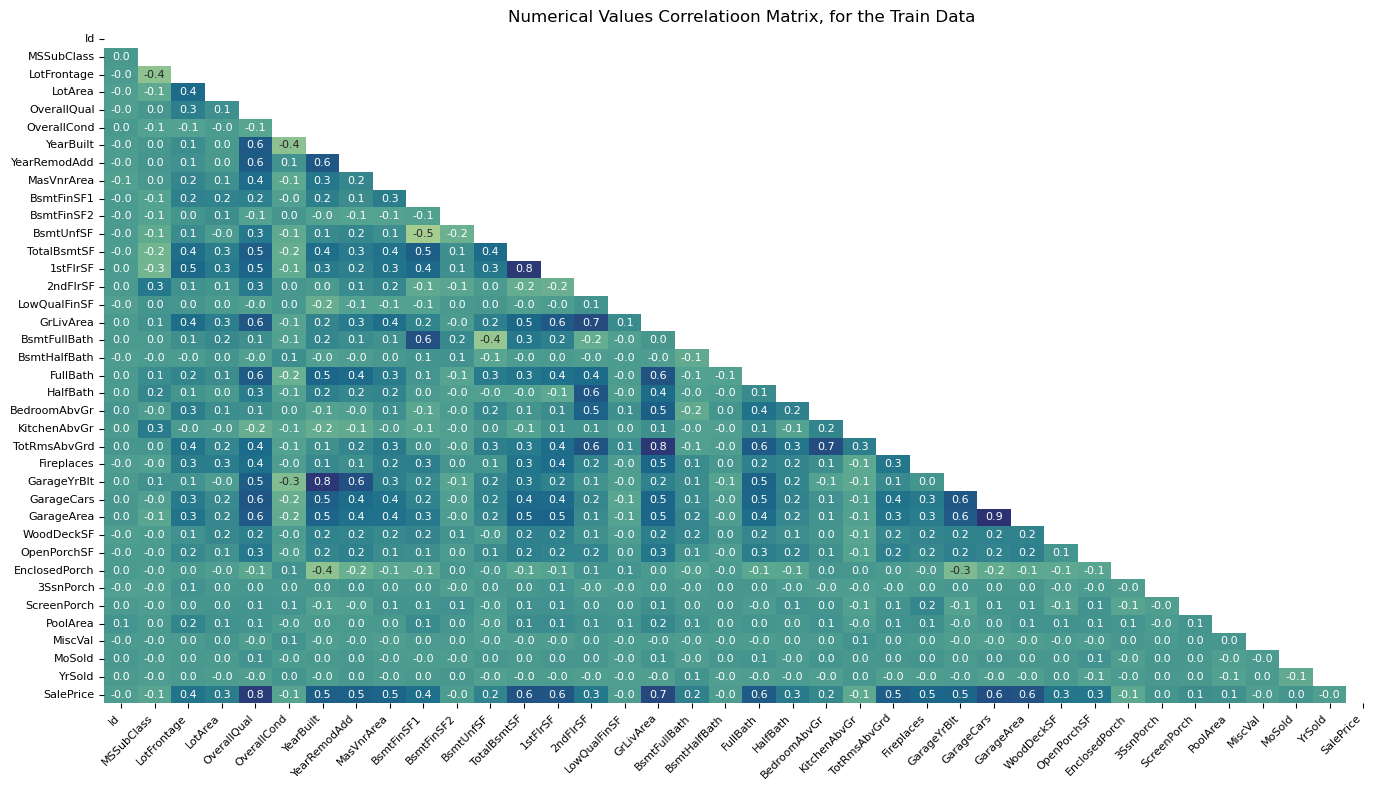

In [107]:
# plot the correlation between the nemerical variables
numerical_cols = train_df.select_dtypes(include=['number'])
corr = numerical_cols.corr()
plt.figure(figsize=(14, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True,cmap='crest',mask=mask,fmt='.1f',cbar=False,annot_kws={"fontsize": 8})
plt.title('Numerical Values Correlatioon Matrix, for the Train Data', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=8)  
plt.yticks(rotation=0, fontsize=8)  
plt.tight_layout()
plt.savefig('numerical_values_correlation.png', dpi=120)
plt.show()

#### **Looking at this:**

- **Size Matters** : Features related to the size of the house (e.g., TotalBsmtSF, 1stFlrSF, GrLivArea, GarageArea) have strong positive correlations with SalePrice.

- **Quality and Condition** : OverallQual and YearBuilt are crucial factors, indicating that both the perceived quality and age of the house influence its selling price.

- **Garage Importance** : Both the number of cars (GarageCars) and the area (GarageArea) in the garage are strongly correlated with SalePrice.

- **Room Count** : The total number of rooms above ground (TotRmsAbvGrd) positively impacts the selling price.

- **Potential Redundancies** : Some features like BsmtFinSF1, BsmtFinSF2, and BsmtUnfSF are highly correlated with TotalBsmtSF, suggesting potential multicollinearity in modeling.

- **Anomalies** : Features like EnclosedPorch and PoolArea show unexpected negative correlations with SalePrice, which might warrant further investigation.

### **Data Cleaning**

##### **Missing Values**

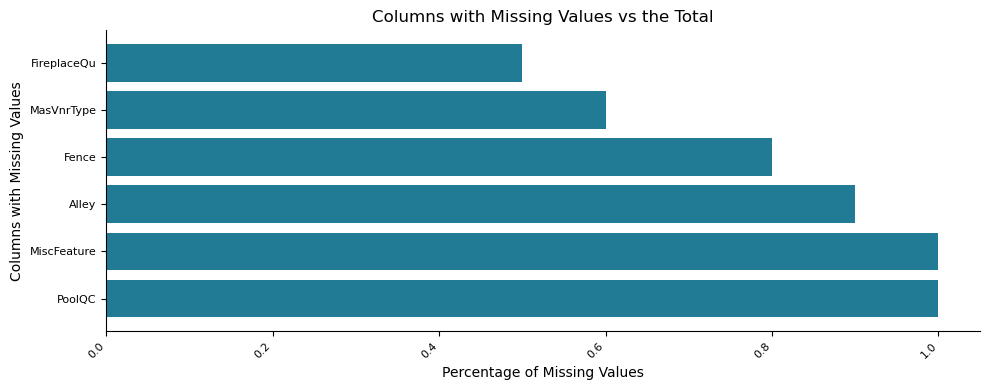

In [110]:
cols_50perc = pd.DataFrame(train_df.isnull().sum().sort_values(ascending=False)).reset_index().rename(columns={'index': 'column_name', 0: 'missing_count'})
cols_50perc = cols_50perc[cols_50perc['missing_count'] > 0]
cols_50perc['missing_percentage'] = cols_50perc['missing_count'] / len(train_df)
cols_50perc = round(cols_50perc[cols_50perc['missing_percentage'] * 100 > 35] ,1)


plt.figure(figsize=(10, 4))
plt.barh(cols_50perc['column_name'], cols_50perc['missing_percentage'], color='#227B94')
plt.title('Columns with Missing Values vs the Total', fontsize=12)
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Columns with Missing Values')
plt.xticks(rotation=45, ha='right', fontsize=8)  
plt.yticks(rotation=0, fontsize=8)  
plt.tight_layout()
sns.despine()
plt.xticks(rotation=45)
plt.show()


Variables that have more than 35% of the values as missing values will be dropped as it's not feasible to fill them using any statistical methods without influencing the overall dataset. 

In [123]:
drop_cols = cols_50perc['column_name'].values.tolist()
train_df = train_df.drop(columns=drop_cols, axis=1)
#check if any of hte columns are left
train_df.columns.isin(drop_cols)


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

##### **Unique Values**

<Figure size 1200x600 with 0 Axes>

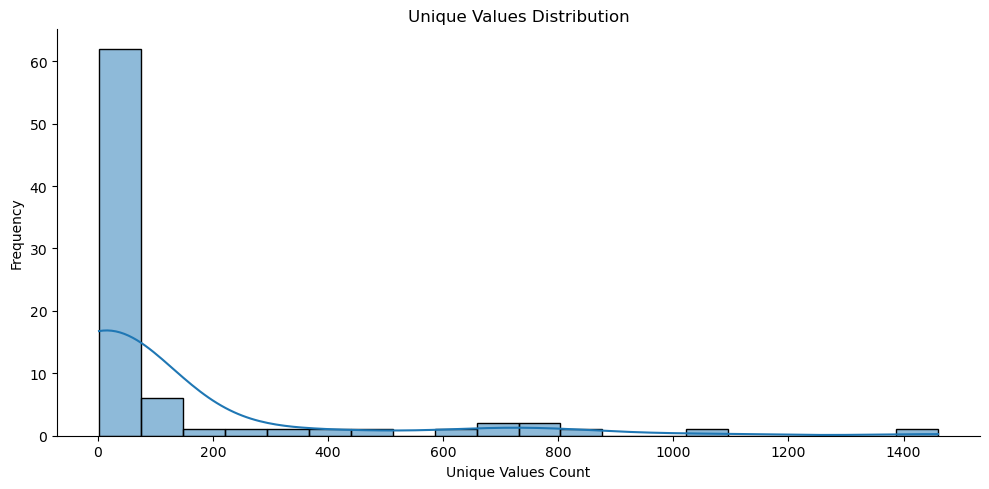

In [10]:
unique_dist = pd.DataFrame(train_df.nunique().sort_values(ascending=False)).reset_index().rename(columns={'index': 'column', 0: 'unique_count'})

plt.figure(figsize=(12, 6))
sns.displot(unique_dist, x='unique_count',kde=True ,bins=20, height=5, aspect=2)
plt.title('Unique Values Distribution', fontsize=12)
plt.xlabel('Unique Values Count')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show();

In [62]:
pd.DataFrame(train_df.nunique().sort_values(ascending=False)).reset_index(names=['column', 'unique_count']).head()

,column,0
0,Id,1460
1,LotArea,1073
2,GrLivArea,861
3,BsmtUnfSF,780
4,1stFlrSF,753


While all columns currently contain unique values, suggesting a lack of duplicates or redundancies, this alone does not confirm the dataset is clean or error-free. Further analysis is necessary to validate data accuracy, consistency, and relevance to the problem at hand.

#### **Duplicate Values**

In [12]:
# check for duplicates with in our dataset 
duplicates = train_df.duplicated().sum()
print(f'There are {duplicates} duplicates in the dataset')

There are 0 duplicates in the dataset


### **Data Distribution & Skewness**

#### What is Skewnewss

Skewness is a dimensionless quantity. It doesn't have units like percentages, meters, or kilograms.

* Skewness of 0: Indicates a perfectly symmetrical distribution.
* Skewness between -0.5 and 0.5: approximately symmetric.
* Skewness between -1 and -0.5 (negative) or between 0.5 and 1 (positive): moderately skewed.
* Skewness less than -1 (negative) or greater than 1 (positive): highly skewed.

> In essence, the higher the absolute value of the skewness, the more the distribution deviates from being symmetrical. The sign tells you which way the tail is leaning.

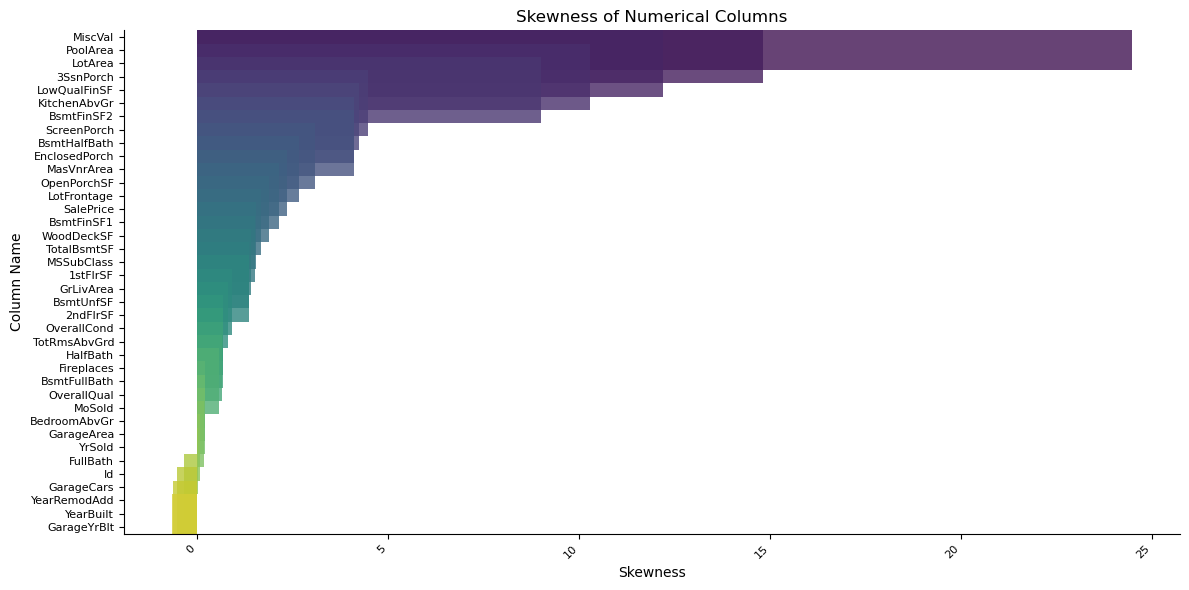

In [73]:
skew_plot = numerical_cols.skew().sort_values(ascending=False)  ##.plot(kind='bar', figsize=(12, 6), color='#227B94')

plt.figure(figsize=(12, 6))
sns.barplot(y=skew_plot.index, x=skew_plot, palette='viridis', alpha=0.8, width=5)
plt.title('Skewness of Numerical Columns', fontsize=12)
plt.xlabel('Skewness',fontsize=10)
plt.ylabel('Column Name', fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=8)  
plt.yticks(rotation=0, fontsize=8)  
sns.despine()
plt.tight_layout()

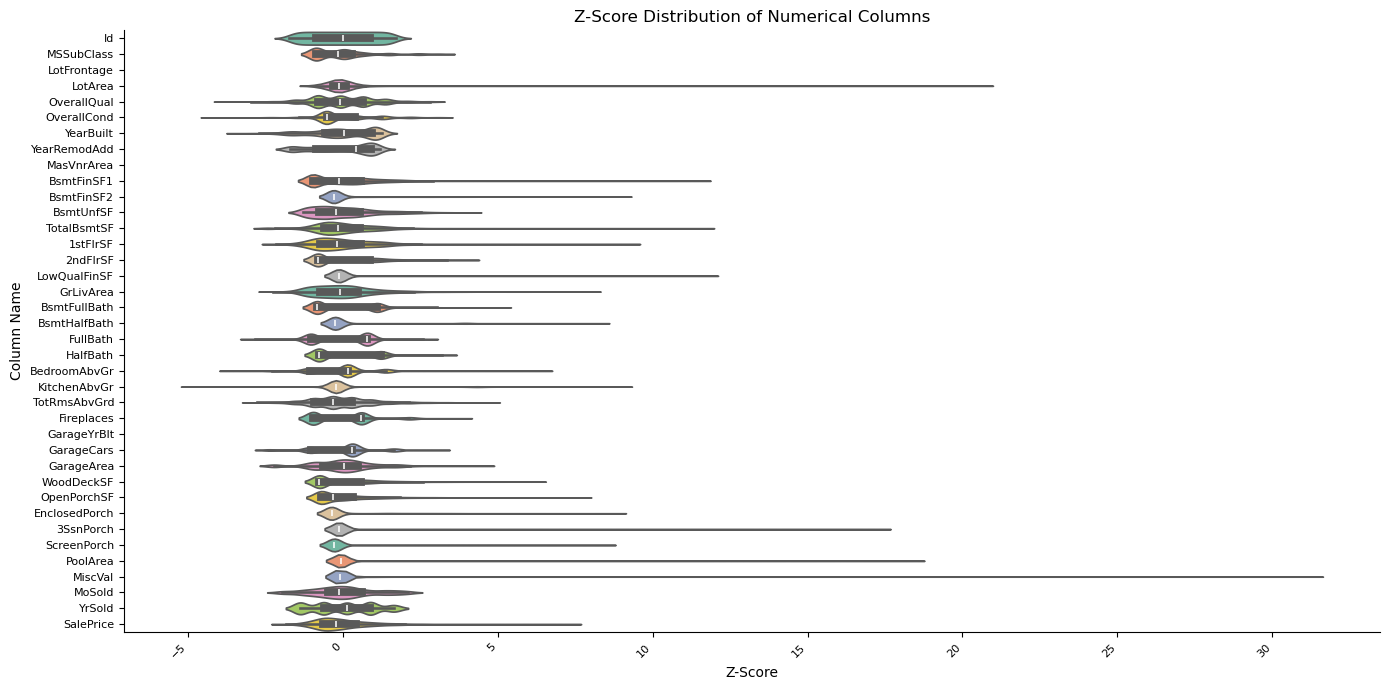

In [124]:
from scipy.stats import zscore
zscore_cols = pd.DataFrame(numerical_cols).apply(zscore)
plt.figure(figsize=(14, 7))
ax = sns.violinplot(data=zscore_cols, orient="h", palette="Set2")
plt.title('Z-Score Distribution of Numerical Columns', fontsize=12)
plt.xlabel('Z-Score', fontsize=10)
plt.ylabel('Column Name', fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=8)  
plt.yticks(rotation=0, fontsize=8)  
plt.tight_layout()
sns.despine()
plt.show()

### **Looking at the Plot**:

- There are some columns with many outliers, several columns show many data points far from the central box, indicating a significant number of potential outliers based on their Z-scores. i.e include ***MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, and MiscVal.***

- There are some columns with fewer outliers: Some columns have fewer or no visible outliers, such as ***YearRemodAdd, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, GarageCars, MoSold, YrSold, and SalePrice. GarageYrBlt and GarageArea*** also show fewer outliers compared to the first group.


Please note all of the skewed variables(columns) need to be addressed since we're working with a regression problem a skewed or expreme values likely affect the the coefficients of regression models, potentially affectin ghte models ablility to generalize to the majority data set. However, since we are using Gradient Boosting algorithm, won't be affected by extreme values as much as distance based or some other algorithms. Nevertheless, handling the skewness of the data can only help since the extremity within the dataset can affect the performance whilst training.

 
**Handling Values**:

 - Address Skewness :- Log Transformation
 - Regularization :- Ridge

## **Data Cleaning**

#### **High Correlation**

In [ ]:
correlated_features = set()
corr_matrix = train_df.corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.95:  # Threshold for high correlation
            colname = corr_matrix.columns[i]
            correlated_features.add(colname)
train_df.drop(columns=correlated_features, inplace=True)

### **Preprocessing**

In this step we will first impute missing values but before doing so it's necessary to split them to avoid any type of data leaakage.

Steps:
    - Handle Skewed Data
    - Handle Missing Values 

#### **Split Data**

In [199]:
X = train_df.drop(columns=['SalePrice','Id'])
y = train_df['SalePrice']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 876
Validation set size: 292
Testing set size: 292


#### **Fix Skewed Data**

In [ ]:
numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
# Define a functioon for skewness
def handle_skewness(df, numerical_cols):
    skew_plot = df[numerical_cols].skew().sort_values(ascending=False)
    skew_threshold = 2
    highly_skewed_cols = skew_plot[abs(skew_plot) > skew_threshold].index.values
    for col in highly_skewed_cols:
        df[col] = np.log1p(df[col])
    return df 

# Assuming X_train, X_test, X_val are defined DataFrames
X_train_transformed = handle_skewness(X_train, numerical_cols)
X_test_transformed = handle_skewness(X_test, numerical_cols)
X_val_transformed = handle_skewness(X_val, numerical_cols)

#### **Missing Data**

In [ ]:
from sklearn.impute import KNNImputer

def handle_missing_data(df):
    imputer = KNNImputer(n_neighbors=5)
    df_imputed = imputer.fit_transform(df)
    return pd.DataFrame(df_imputed, columns=df.columns)

#convert the values
X_train_imputed = handle_missing_data(X_train_transformed)
X_test_imputed = handle_missing_data(X_test_transformed)
X_val_imputed = handle_missing_data(X_val_transformed)

### **Feature Engineering**

In [187]:
unique_counts = train_df.nunique()
unique_list = pd.DataFrame({
    'column_name': unique_counts.index,
    'unique_count': unique_counts.values,
    'is_categorical': unique_counts.index.isin(categorical_cols)
})
unique_column_names = unique_list[unique_list['is_categorical']]['column_name'].values

array(['Neighborhood', 'Exterior2nd', 'Exterior1st', 'SaleType',
       'Condition1', 'HouseStyle', 'RoofMatl', 'Condition2', 'Functional',
       'SaleCondition', 'GarageType', 'Heating', 'Foundation',
       'RoofStyle', 'BsmtFinType2', 'BsmtFinType1', 'BldgType',
       'LotConfig', 'ExterCond', 'GarageQual', 'HeatingQC', 'MSZoning',
       'GarageCond', 'Electrical', 'ExterQual', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'LandContour', 'LotShape', 'KitchenQual',
       'GarageFinish', 'PavedDrive', 'LandSlope', 'Street', 'CentralAir',
       'Utilities'], dtype=object)

In [203]:
categorical_columns_in_df = [col for col in train_df.columns if col in categorical_cols]


In [ ]:
def encode_binary(df_train, df_test, df_val, cols):
    """
    Encode binary columns as 0/1.
    Example: 'Street' (Grvl, Pave) → 0, 1.
    """
    cols = []
    # Map first unique value to 0, others to 1
    unique_vals = df_train[col].unique()
    mapping = {val: 0 if val == unique_vals[0] else 1 for val in unique_vals}
    
    df_train[col] = df_train[col].map(mapping)
    df_test[col] = df_test[col].map(mapping)
    df_val[col] = df_val[col].map(mapping)
    return df_train, df_test, df_val


In [ ]:
from sklearn.preprocessing import OneHotEncoder

def handle_low_cardinality(df_train, df_test, df_val, col):
    # Fill missing values with "missing"
    df_train[col] = df_train[col].fillna('missing')
    df_test[col] = df_test[col].fillna('missing')
    df_val[col] = df_val[col].fillna('missing')
    
    # One-hot encode
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    ohe.fit(df_train[[col]])
    
    # Transform train/test
    train_encoded = pd.DataFrame(ohe.transform(df_train[[col]]), 
                              columns=ohe.get_feature_names_out([col]), 
                              index=df_train.index)
    test_encoded = pd.DataFrame(ohe.transform(df_test[[col]]), 
                             columns=ohe.get_feature_names_out([col]), 
                             index=df_test.index)
    val_encoded = pd.DataFrame(ohe.transform(df_val[[col]]), 
                             columns=ohe.get_feature_names_out([col]), 
                             index=df_val.index)
    
    # Drop original column and merge encoded features
    df_train = pd.concat([df_train.drop(col, axis=1), train_encoded], axis=1)
    df_test = pd.concat([df_test.drop(col, axis=1), test_encoded], axis=1)
    df_val = pd.concat([df_val.drop(col, axis=1), val_encoded], axis=1)
    return df_train, df_test, df_val

In [ ]:
from category_encoders import TargetEncoder

def handle_high_cardinality(df_train, df_test, df_val,col, target_train):
    # Fill missing values with "missing"
    df_train[col] = df_train[col].fillna('missing')
    df_test[col] = df_test[col].fillna('missing')
    df_val[col] = df_val[col].fillna('missing')
    
    # Target encode with smoothing
    encoder = TargetEncoder(smoothing=10)
    df_train[col] = encoder.fit_transform(df_train[col], target_train)
    df_test[col] = encoder.transform(df_test[col])
    df_val[col] = encoder.transform(df_val[col])
    return df_train, df_test, df_val



In [ ]:
def handle_ordinal(df_train, df_test, df_val col, mapping, default_value=2):
    """
    mapping: Dictionary defining order (e.g., {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    default_value: Value to assign if missing/unseen categories appear
    """
    # Fill missing values with the mode (or a placeholder)
    df_train[col] = df_train[col].fillna('missing')
    df_test[col] = df_test[col].fillna('missing')
    df_val[col] = df_val[col].fillna('missing')
    
    # Map categories to numbers
    df_train[col] = df_train[col].map(mapping).fillna(default_value).astype(int)
    df_test[col] = df_test[col].map(mapping).fillna(default_value).astype(int)
    df_val[col] = df_val[col].map(mapping).fillna(default_value).astype()
    return df_train, df_test, df_val

# Example usage (define mapping first):
qual_mapping = {'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}
X_train, X_test = handle_ordinal(X_train, X_test, 'ExterQual', qual_mapping)